![title](img/atp-stats-analysis.jpg)

# ATP ranking stats

 Importing the required libraries.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

The source of this project's data is [ATP World Tour tennis data](https://datahub.io/sports-data/atp-world-tour-tennis-data/r/rankings_1973-2017.csv).

In [2]:
!mkdir -p data/
if not os.path.exists('data/rankings_1973-2017.csv'):
    !curl -sSL -o data/rankings_1973-2017.csv https://datahub.io/sports-data/atp-world-tour-tennis-data/r/rankings_1973-2017.csv

In [3]:
atp_rankings = pd.read_csv('data/rankings_1973-2017.csv', dtype={'week_title': object, 'week_year': int, 'week_month': int, 'week_day': int, 'rank_text': object, 'rank_number': int, 'move_position': float, 'move_direction': object, 'player_age': float, 'ranking_points': int, 'tourneys_played': int, 'player_url': object, 'player_slug': object, 'player_id': object})

First of all, let's take a look at the size of our data set. The shape attribute gives us the total number of rows and the total number of columns in our data structure.

In [4]:
atp_rankings.shape

(2694539, 14)

We can also look at what type of data each column contains.

In [5]:
atp_rankings.dtypes

week_title          object
week_year            int64
week_month           int64
week_day             int64
rank_text           object
rank_number          int64
move_positions     float64
move_direction      object
player_age         float64
ranking_points       int64
tourneys_played      int64
player_url          object
player_slug         object
player_id           object
dtype: object

## Looking at the data

Since we don't need to use the whole data set for our project and only need columns titled week_year, week_month, week_day, rank_number and player_age, let's create a data subset of the selected columns and assign this value to a new variable.

In [6]:
rankings_subset = atp_rankings[['week_year', 'week_month', 'week_day', 'rank_number', 'player_age', 'player_slug']]

A common occurrence in data sets is missing data. This can have a considerable effect on the conclusions that can be drawn from the data. Therefore, let's take a look at how much missing data is in our data set. We can use the isnull method from numpy to count how many values in our data set are missing. The isnull method also allows us to look at specific columns of our data.

In [7]:
print('The amount of missing data:',(np.count_nonzero(rankings_subset.isnull())))
print('The amount of missing data in the years column:',(np.count_nonzero(rankings_subset['week_year'].isnull())))
print('The amount of missing data in the rankings column:', (np.count_nonzero(rankings_subset['rank_number'].isnull())))
print('The amount of missing data in the players age column:', (np.count_nonzero(rankings_subset['player_age'].isnull())))

The amount of missing data: 214559
The amount of missing data in the years column: 0
The amount of missing data in the rankings column: 0
The amount of missing data in the players age column: 214559


Since all of the missing values are in the player_age column, we'll need to keep that in mind once we start analysing the data.

In the tennis ranking system a player's ranking is based on the cumulative amount of points earned at tournaments in the previous 52 weeks. Therefore, the rankings catch up to the season only at the end of the year when a player's ranking includes solely the events of the current year. That is why year-end rankings from each year are the best evaluators of a player’s performance from that calendar year. In order to find the year-end rankings we need to sort through the data and find the last set of rankings from each year.

In [8]:
def find_all_years(df):
    all_years = df['week_year'].unique()
    all_years.sort()
    all_years_list = all_years.tolist()
    return all_years_list

def find_last_date(df, year):
    search_year = df[df['week_year'] == year]
    search_month = sorted(search_year['week_month'].unique())[-1]
    search_year_search_month = search_year[search_year['week_month'] == search_month]
    search_day = sorted(search_year_search_month['week_day'].unique())[-1]
    return search_month, search_day

def year_end_top_100(df, year):
    last_month, last_day = find_last_date(df, year)
    search_year = df[df['week_year'] == year]
    year_end_month = search_year[search_year['week_month'] == last_month]
    year_end_day = year_end_month[year_end_month['week_day'] == last_day]
    sorted_top = year_end_day.sort_values(by=['rank_number'])
    top_100 = sorted_top[:100]
    return top_100

Let's take a look at what year's rankings are in the data set.

In [9]:
print(find_all_years(rankings_subset))

[1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


Now let's see if we can find the five highest ranked players from 2017.

In [10]:
year_end_top_100(rankings_subset, 2017).head()

,week_year,week_month,week_day,rank_number,player_age,player_slug
0,2017,11,20,1,31.0,rafael-nadal
1,2017,11,20,2,36.0,roger-federer
2,2017,11,20,3,26.0,grigor-dimitrov
3,2017,11,20,4,20.0,alexander-zverev
4,2017,11,20,5,24.0,dominic-thiem


We are going to sort out the top 100 players from each year based on the last rankings of that year and put them together into one data set using the concat method from pandas.

In [11]:
appended_df = []
for year in find_all_years(rankings_subset):
    subset_year = year_end_top_100(rankings_subset, year)
    appended_df.append(subset_year)
appended_df = pd.concat(appended_df)

When we look at the new data set we find that most of the data from 1980, 1981 and 1982 is missing, and from 1983 half of the data is missing. However, from every other year we have a complete year-end top 100.

In [12]:
appended_df.groupby('week_year').size()

week_year
1973    100
1974    100
1975    100
1976    100
1977    100
1978    100
1979    100
1980      2
1981      1
1982      1
1983     50
1984    100
1985    100
1986    100
1987    100
1988    100
1989    100
1990    100
1991    100
1992    100
1993    100
1994    100
1995    100
1996    100
1997    100
1998    100
1999    100
2000    100
2001    100
2002    100
2003    100
2004    100
2005    100
2006    100
2007    100
2008    100
2009    100
2010    100
2011    100
2012    100
2013    100
2014    100
2015    100
2016    100
2017    100
dtype: int64

From that data frame we will break down each calculation by year and look at the average age of players, the age of the youngest player and the age of the oldest player. The groupby statement takes the week_year column and splits our data by unique values of that column. Then it will calculate the mean, min and max of each subset (excluding NaN values) and return a single data frame.

In [13]:
average_age = appended_df.groupby('week_year')['player_age'].agg(average_age=pd.NamedAgg(column='average_age', aggfunc='mean'), youngest=pd.NamedAgg(column='youngest', aggfunc='min'), oldest=pd.NamedAgg(column='oldest', aggfunc='max'))
average_age.head(n=10)

,average_age,youngest,oldest
week_year,,,
1973,26.450000,17.0,39.0
1974,26.760000,17.0,40.0
1975,26.620000,18.0,41.0
1976,26.949495,19.0,42.0
1977,27.010000,12.0,43.0
1978,26.190000,18.0,44.0
1979,26.080000,19.0,38.0
1980,28.000000,28.0,28.0
1981,21.000000,21.0,21.0


Because we don't want to include incomplete data, we use the .drop method from pandas to remove data from from 1980, 1981 and 1982.

In [14]:
clean_data = average_age.drop(average_age.index[[7,8,9]])
clean_data.head(n=10)

,average_age,youngest,oldest
week_year,,,
1973,26.450000,17.0,39.0
1974,26.760000,17.0,40.0
1975,26.620000,18.0,41.0
1976,26.949495,19.0,42.0
1977,27.010000,12.0,43.0
1978,26.190000,18.0,44.0
1979,26.080000,19.0,38.0
1983,25.120000,18.0,32.0
1984,24.610000,17.0,33.0


Now it is time to take the above data and use Python's plotting library matplotlib to plot it.

## Plotting data

Text(0, 0.5, 'Age')

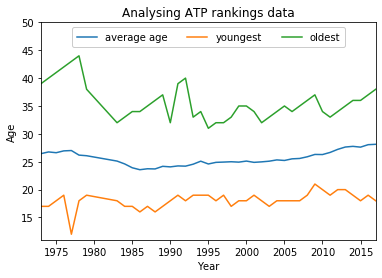

In [15]:
data_graph = clean_data.plot()
data_graph.set_ylim([11,50])
data_graph.legend(['average age','youngest','oldest'], fancybox=True, framealpha=1, borderpad=0.5, loc='upper center',ncol=3)
data_graph.set_title('Analysing ATP rankings data')
data_graph.set_xlabel('Year')
data_graph.set_ylabel('Age')

We can see that the average age of players in the top 100 at the end of each year has been steadily increasing from the late 1980s and has never been as high as it is at the moment. The age of the oldest player and the youngest player doesn't seem to have a drastic effect on the average but it's interesting to see nonetheless.

Text(17.200000000000003, 0.5, 'Age')

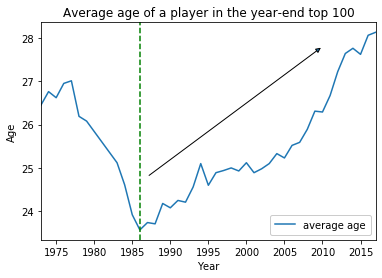

In [16]:
data1 = clean_data.plot(y='average_age', label='average age')
data1.legend(fancybox=True, framealpha=1, borderpad=0.5, loc='lower right')
data1.axvline(1986, color='g', ls='--')
data1.annotate('', xy=(2010, 27.8), xytext=(1987, 24.8),
            arrowprops=dict(arrowstyle='-|>'),
            )
data1.set_title('Average age of a player in the year-end top 100')
data1.set_xlabel('Year')
data1.set_ylabel('Age')
data_graph.set_ylabel('Age')

Text(0, 0.5, 'Age')

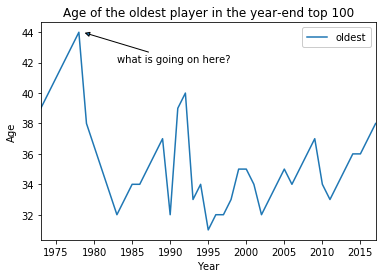

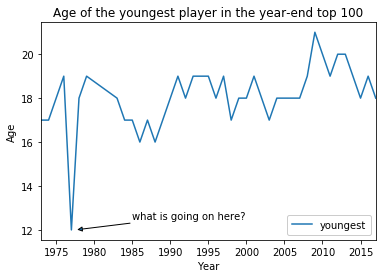

In [17]:
data2 = clean_data.plot(y='oldest')
data2.legend(fancybox=True, framealpha=1, borderpad=0.5, loc='upper right')
data2.annotate('what is going on here?', xy=(1978.5, 44), xytext=(1983, 42),
            arrowprops=dict(arrowstyle='-|>'),
            )
data2.set_title('Age of the oldest player in the year-end top 100')
data2.set_xlabel('Year')
data2.set_ylabel('Age')
data3 = clean_data.plot(y='youngest')
data3.legend(fancybox=True, framealpha=1, borderpad=0.5, loc='lower right')
data3.annotate('what is going on here?', xy=(1977.5, 12), xytext=(1985, 12.5),
            arrowprops=dict(arrowstyle='-|>'),
            )
data3.set_title('Age of the youngest player in the year-end top 100')
data3.set_xlabel('Year')
data3.set_ylabel('Age')

In the youngest players graph we can see that there was a very young player (aged 12) somewhere between 1975 and 1980. Since this seems a bit too young for a professional tennis player, we will take a closer look at that. Furthermore, when we look at the oldest player graph we see that there are some unusually high values between 1975 and 1980. This also needs some looking into because we want to make sure that we don't have any incorrect data there.

In [18]:
average_age = appended_df.groupby('week_year')['player_age'].agg(youngest=pd.NamedAgg(column='youngest', aggfunc='min'))
average_age.head(n=6)

,youngest
week_year,
1973,17.0
1974,17.0
1975,18.0
1976,19.0
1977,12.0
1978,18.0


When we look at rankings from 1977 on the ATP website we find a player named Danny Granot who is listed as born in 1965 but actually competed between 1992 and 1997. Therefore it must be an error and instead the youngest player in the top 100 of that year was John McEnroe who was 18 years old at the time. Since there is only one value 12 in the youngest column we can use pandas replace method to insert the correct value into our data set.

When we look at rankings from 1973 on the ATP website we see that the oldest player in the top 100 at the end of that year was Ken Rosewall (born in 1934) and because he continued to compete at a high level for many years to come, he was also the oldest player in the next five year-end rankings. So the oldest player in the 1978 rankings was Ken Rosewall, aged 44 that year and it is indeed the correct value.

In [19]:
clean_data.youngest = clean_data.youngest.replace({12.0: 18})
clean_data.head(n=6)

,average_age,youngest,oldest
week_year,,,
1973,26.450000,17.0,39.0
1974,26.760000,17.0,40.0
1975,26.620000,18.0,41.0
1976,26.949495,19.0,42.0
1977,27.010000,18.0,43.0
1978,26.190000,18.0,44.0


Let's take a look at the graph again now that we have the correct values in the data set.

Text(0, 0.5, 'Age')

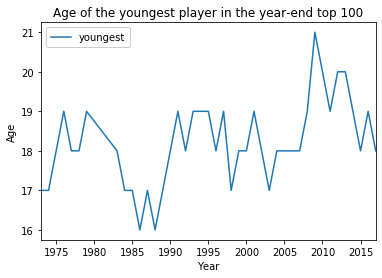

In [20]:
data4 = clean_data.plot(y='youngest')
data4.legend(fancybox=True, framealpha=1, borderpad=0.5, loc='upper left')
data4.set_title('Age of the youngest player in the year-end top 100')
data4.set_xlabel('Year')
data4.set_ylabel('Age')

## Other possibilities

Another way to visualize data is to use Seaborn. Seaborn is a plotting library just like matplotlib and it is in fact built on top of matplotlib and closely integrated with pandas data structures. It will give us plots that look more sophisticated.

Text(0, 0.5, 'Age')

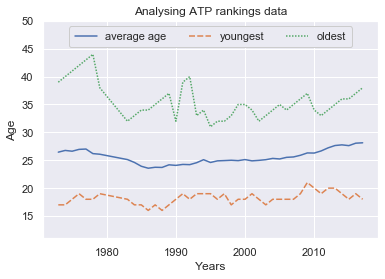

In [21]:
sns.set(style="darkgrid")
sns.lineplot(data=clean_data)
plt.ylim([11,50])
plt.legend(['average age','youngest','oldest'], fancybox=True, framealpha=1, borderpad=0.5, loc='upper center',ncol=3)
plt.title('Analysing ATP rankings data')
plt.xlabel('Years')
plt.ylabel('Age')

In addition, it would be interesting to find out how many players under the age of 18 or 21 (i.e. teenagers) are in the top 100 at the end of each year, since this would give some additional information about how men's professional tennis has changed and evolved over the years.